# ⛰ U.S. Fourteeners ⛰

Our goal: Make a map of U.S. mountain peaks that are 14,000 feet or higher.

Our data:
- [A cartographic boundary shapefile of the U.S. from the Census Bureau](https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html) (20m resolution is fine)
- [A pipe-delimted data file of geographic features from the U.S. Board on Geographic Names](https://geonames.usgs.gov/domestic/download_data.htm)

Our steps:
1. Import dependencies
2. Download the data if it doesn't exist already
3. Inflate the zipfiles
4. Load the shapefile into a geopandas data frame and re-project into something U.S.-centric
5. Load the geographic name data into a pandas data frame
6. Filter the geographic name data to target 14K peaks
7. Turn the name data into a geodataframe
8. Map the name data on top of the U.S. map

### Step 1: Import dependencies

- `os`: To check if we've already downloaded the data files, and to list the contents of the directory
- `zipfile`: To inflate the zipfiles of data
- `pandas`: To manage the name data
- `geopandas`: To manage the shapefile data
- `requests`: To download the data files if they're not already there
- `shapely.geometry.Point`: To convert lat/lng coordinates into mappable objects

In [1]:
import os
import zipfile

import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import Point

In [2]:
# show plots inline
%matplotlib inline

### Step 2: Download the data if it doesn't exist already

In [3]:
# shapefile link
us_shapefile = 'http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip'

# geographic name data link
name_data = 'https://geonames.usgs.gov/docs/stategaz/NationalFile_20180801.zip'

# for each file to download
for f in [us_shapefile, name_data]:
    
    # split URL string to grab the name of the file
    fname = f.split('/')[-1]
    
    # check to see if the file exists already
    if not os.path.isfile('data/' + fname):
        
        # if not, let us know it's downloading
        print('Downloading', fname)
        
        # fetch the URL with requests
        r = requests.get(f, stream=True)
        
        # open a file with that name in write binary mode
        with open('data/' + fname, 'wb') as f:
            
            # iterate over blocks and write to file
            for block in r.iter_content(1024):
                f.write(block)

### Step 3: Inflate the zipfiles

In [4]:
# get a list of zipfiles in this directory
target_files = [x for x in os.listdir('data') if x.endswith('.zip')]

# for each zipfile
for z in target_files:
    
    # open it as a Zipfile object
    with zipfile.ZipFile('data/' + z, 'r') as zf:

        # and extract everything into this directory
        zf.extractall('data/')

### Step 4: Load the shapefile into geopandas

We'll also re-project the data into [USA Contiguous Albers Equal Area Conic,](http://spatialreference.org/ref/esri/usa-contiguous-albers-equal-area-conic/) aka _ESRI:102003_.

In [5]:
# http://spatialreference.org/ref/esri/usa-contiguous-albers-equal-area-conic/
states = gpd.read_file('data/cb_2017_us_state_20m.shp').to_crs({'init': 'ESRI:102003'})

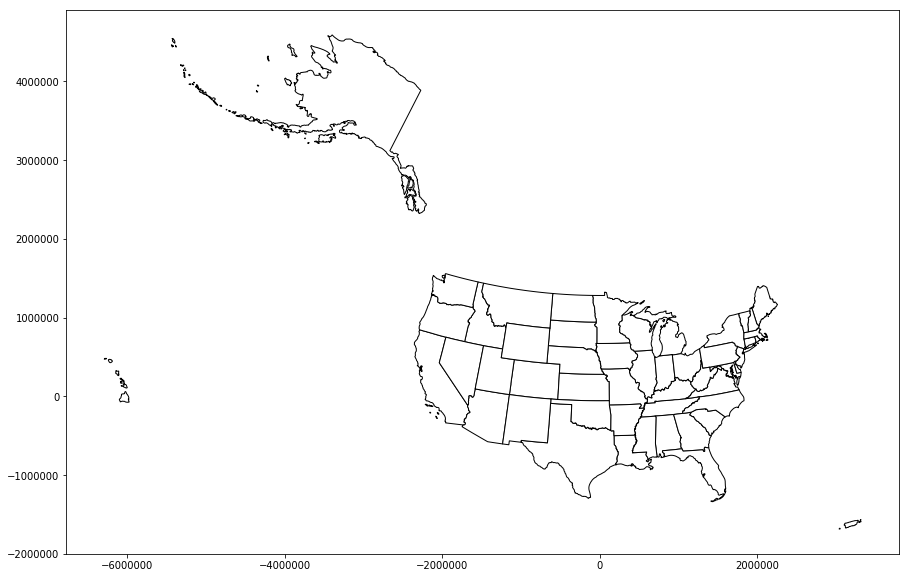

In [6]:
# plot the boundary data to see what it looks like
states.plot(figsize=(30,10),
            edgecolor='black',
            color='white')

### Step 5: Load the geographic place name data into pandas

In [7]:
places = pd.read_csv('data/NationalFile_20180801.txt', sep='|')

In [8]:
places.head()

,FEATURE_ID,FEATURE_NAME,FEATURE_CLASS,STATE_ALPHA,STATE_NUMERIC,COUNTY_NAME,COUNTY_NUMERIC,PRIMARY_LAT_DMS,PRIM_LONG_DMS,PRIM_LAT_DEC,PRIM_LONG_DEC,SOURCE_LAT_DMS,SOURCE_LONG_DMS,SOURCE_LAT_DEC,SOURCE_LONG_DEC,ELEV_IN_M,ELEV_IN_FT,MAP_NAME,DATE_CREATED,DATE_EDITED
0,0,Bruceville Cemetery,Cemetery,CO,8,Boulder,13.0,400058N,1051226W,40.016099,-105.207171,NaN,NaN,NaN,NaN,1598.0,5243.0,Niwot,05/04/2015,10/22/2015
1,399,Agua Sal Creek,Stream,AZ,4,Apache,1.0,362740N,1092842W,36.461112,-109.478439,362053N,1090915W,36.348058,-109.154266,1645.0,5397.0,Fire Dance Mesa,02/08/1980,NaN
2,400,Agua Sal Wash,Valley,AZ,4,Apache,1.0,363246N,1093103W,36.546112,-109.517607,362740N,1092842W,36.461112,-109.478439,1597.0,5239.0,Little Round Rock,02/08/1980,NaN
3,401,Aguaje Draw,Valley,AZ,4,Apache,1.0,343417N,1091313W,34.571428,-109.220370,344308N,1085826W,34.718800,-108.973900,1750.0,5741.0,Kearn Lake,02/08/1980,01/14/2008
4,402,Arlington State Wildlife Area,Park,AZ,4,Maricopa,13.0,331455N,1124625W,33.248655,-112.773504,NaN,NaN,NaN,NaN,231.0,758.0,Spring Mountain,02/08/1980,NaN


### Step 6: Filter the data

This data file includes features of all types. We just want the features with `FEATURE_CLASS` "Summit."

Next, we'll filter the summit data to only include peaks that are 14K feet or higher.

In [9]:
# filter to get just the summits
summits = places[places.FEATURE_CLASS == 'Summit']

In [10]:
summits.head()

,FEATURE_ID,FEATURE_NAME,FEATURE_CLASS,STATE_ALPHA,STATE_NUMERIC,COUNTY_NAME,COUNTY_NUMERIC,PRIMARY_LAT_DMS,PRIM_LONG_DMS,PRIM_LAT_DEC,PRIM_LONG_DEC,SOURCE_LAT_DMS,SOURCE_LONG_DMS,SOURCE_LAT_DEC,SOURCE_LONG_DEC,ELEV_IN_M,ELEV_IN_FT,MAP_NAME,DATE_CREATED,DATE_EDITED
29,427,Potter Mesa,Summit,AZ,4,Apache,1.0,344528N,1094013W,34.757824,-109.670291,NaN,NaN,NaN,NaN,1768.0,5800.0,Milky Ranch,02/08/1980,05/16/2017
31,429,Black Mesa,Summit,AZ,4,Gila,7.0,332846N,1102246W,33.479499,-110.379544,NaN,NaN,NaN,NaN,1251.0,4104.0,Natural Corral,02/08/1980,NaN
32,430,Black Mesa,Summit,AZ,4,Mohave,15.0,342300N,1134003W,34.383351,-113.667434,NaN,NaN,NaN,NaN,831.0,2726.0,Signal,02/08/1980,NaN
33,431,Black Mesa,Summit,AZ,4,Mohave,15.0,345709N,1141938W,34.952504,-114.327179,NaN,NaN,NaN,NaN,1169.0,3835.0,Warm Springs,02/08/1980,NaN
35,433,Third Mesa,Summit,AZ,4,Navajo,17.0,360129N,1103355W,36.024723,-110.565415,NaN,NaN,NaN,NaN,1859.0,6099.0,Rocky Ridge SE,02/08/1980,NaN


In [11]:
# filter the summits to get those that are >= 14K
fourteeners = summits[summits.ELEV_IN_FT >= 14000]

In [12]:
fourteeners.head()

,FEATURE_ID,FEATURE_NAME,FEATURE_CLASS,STATE_ALPHA,STATE_NUMERIC,COUNTY_NAME,COUNTY_NUMERIC,PRIMARY_LAT_DMS,PRIM_LONG_DMS,PRIM_LAT_DEC,PRIM_LONG_DEC,SOURCE_LAT_DMS,SOURCE_LONG_DMS,SOURCE_LAT_DEC,SOURCE_LONG_DEC,ELEV_IN_M,ELEV_IN_FT,MAP_NAME,DATE_CREATED,DATE_EDITED
138377,175209,Capitol Peak,Summit,CO,8,Pitkin,97.0,390901N,1070459W,39.150265,-107.083103,NaN,NaN,NaN,NaN,4304.0,14121.0,Capitol Peak,10/13/1978,NaN
138722,175555,Snowmass Mountain,Summit,CO,8,Pitkin,97.0,390708N,1070359W,39.118877,-107.066435,NaN,NaN,NaN,NaN,4294.0,14088.0,Snowmass Mountain,10/13/1978,NaN
139739,176576,El Diente Peak,Summit,CO,8,Dolores,33.0,375022N,1080019W,37.839438,-108.005347,NaN,NaN,NaN,NaN,4310.0,14140.0,Dolores Peak,10/13/1978,NaN
142664,179522,Mount of the Holy Cross,Summit,CO,8,Eagle,37.0,392800N,1062854W,39.466746,-106.481638,NaN,NaN,NaN,NaN,4268.0,14002.0,Mount of the Holy Cross,10/13/1978,05/23/2018
142809,179667,Quandary Peak,Summit,CO,8,Summit,117.0,392350N,1060623W,39.397210,-106.106409,NaN,NaN,NaN,NaN,4348.0,14265.0,Breckenridge,10/13/1978,NaN


In [13]:
# how many'd we end up with?
fourteeners.shape

(89, 20)

In [14]:
# what's the breakdown by state?
fourteeners.groupby('STATE_ALPHA').size()

STATE_ALPHA
AK    22
CA    11
CO    52
WA     4
dtype: int64

In [15]:
# slice out just the columns we care about
columns_we_care_about = ['FEATURE_ID', 'FEATURE_NAME', 'STATE_ALPHA',
                         'PRIM_LAT_DEC', 'PRIM_LONG_DEC', 'ELEV_IN_FT']

mtns_to_map = fourteeners[columns_we_care_about]

In [16]:
# let's sort what we've got and take a look
mtns_to_map.sort_values('ELEV_IN_FT', ascending=False).head()

,FEATURE_ID,FEATURE_NAME,STATE_ALPHA,PRIM_LAT_DEC,PRIM_LONG_DEC,ELEV_IN_FT
1751162,1884386,South Peak,AK,63.069150,-151.006240,20233.0
1294557,1400397,Churchill Peaks,AK,63.069111,-151.006240,20233.0
1308395,1414314,Denali,AK,63.069102,-151.006262,20233.0
1294187,1400026,Carter Horn,AK,63.067778,-150.998611,19875.0
1296159,1402007,Farthing Horn,AK,63.071667,-151.002222,19819.0


### Step 7: Turn the filtered name data into a geodataframe

In [17]:
# use the PRIM_LONG_DEC and PRIM_LAT_DEC columns to create a series of points
points = mtns_to_map.apply(lambda row: Point(row.PRIM_LONG_DEC, row.PRIM_LAT_DEC), axis=1)

# create a geodataframe from this series and the original data frame
# and set the initial CRS as WGS84 - https://epsg.io/4326
gis_14ers = gpd.GeoDataFrame(mtns_to_map,
                             geometry=points,
                             crs={'init': 'EPSG:4326'})

# convert CRS to match our GIS data
gis_14ers = gis_14ers.to_crs({'init': 'ESRI:102003'})

In [18]:
gis_14ers.head()

,FEATURE_ID,FEATURE_NAME,STATE_ALPHA,PRIM_LAT_DEC,PRIM_LONG_DEC,ELEV_IN_FT,geometry
138377,175209,Capitol Peak,CO,39.150265,-107.083103,14121.0,POINT (-946837.1111582981 240240.0403453481)
138722,175555,Snowmass Mountain,CO,39.118877,-107.066435,14088.0,POINT (-945828.411180758 236579.9663953697)
139739,176576,El Diente Peak,CO,37.839438,-108.005347,14140.0,POINT (-1043732.944605784 104056.6904862323)
142664,179522,Mount of the Holy Cross,CO,39.466746,-106.481638,14002.0,POINT (-891763.9440453032 269663.5184427355)
142809,179667,Quandary Peak,CO,39.397210,-106.106409,14265.0,POINT (-860789.8495616363 258456.3165830773)


### Step 8: Plot the 14er data on top of the map

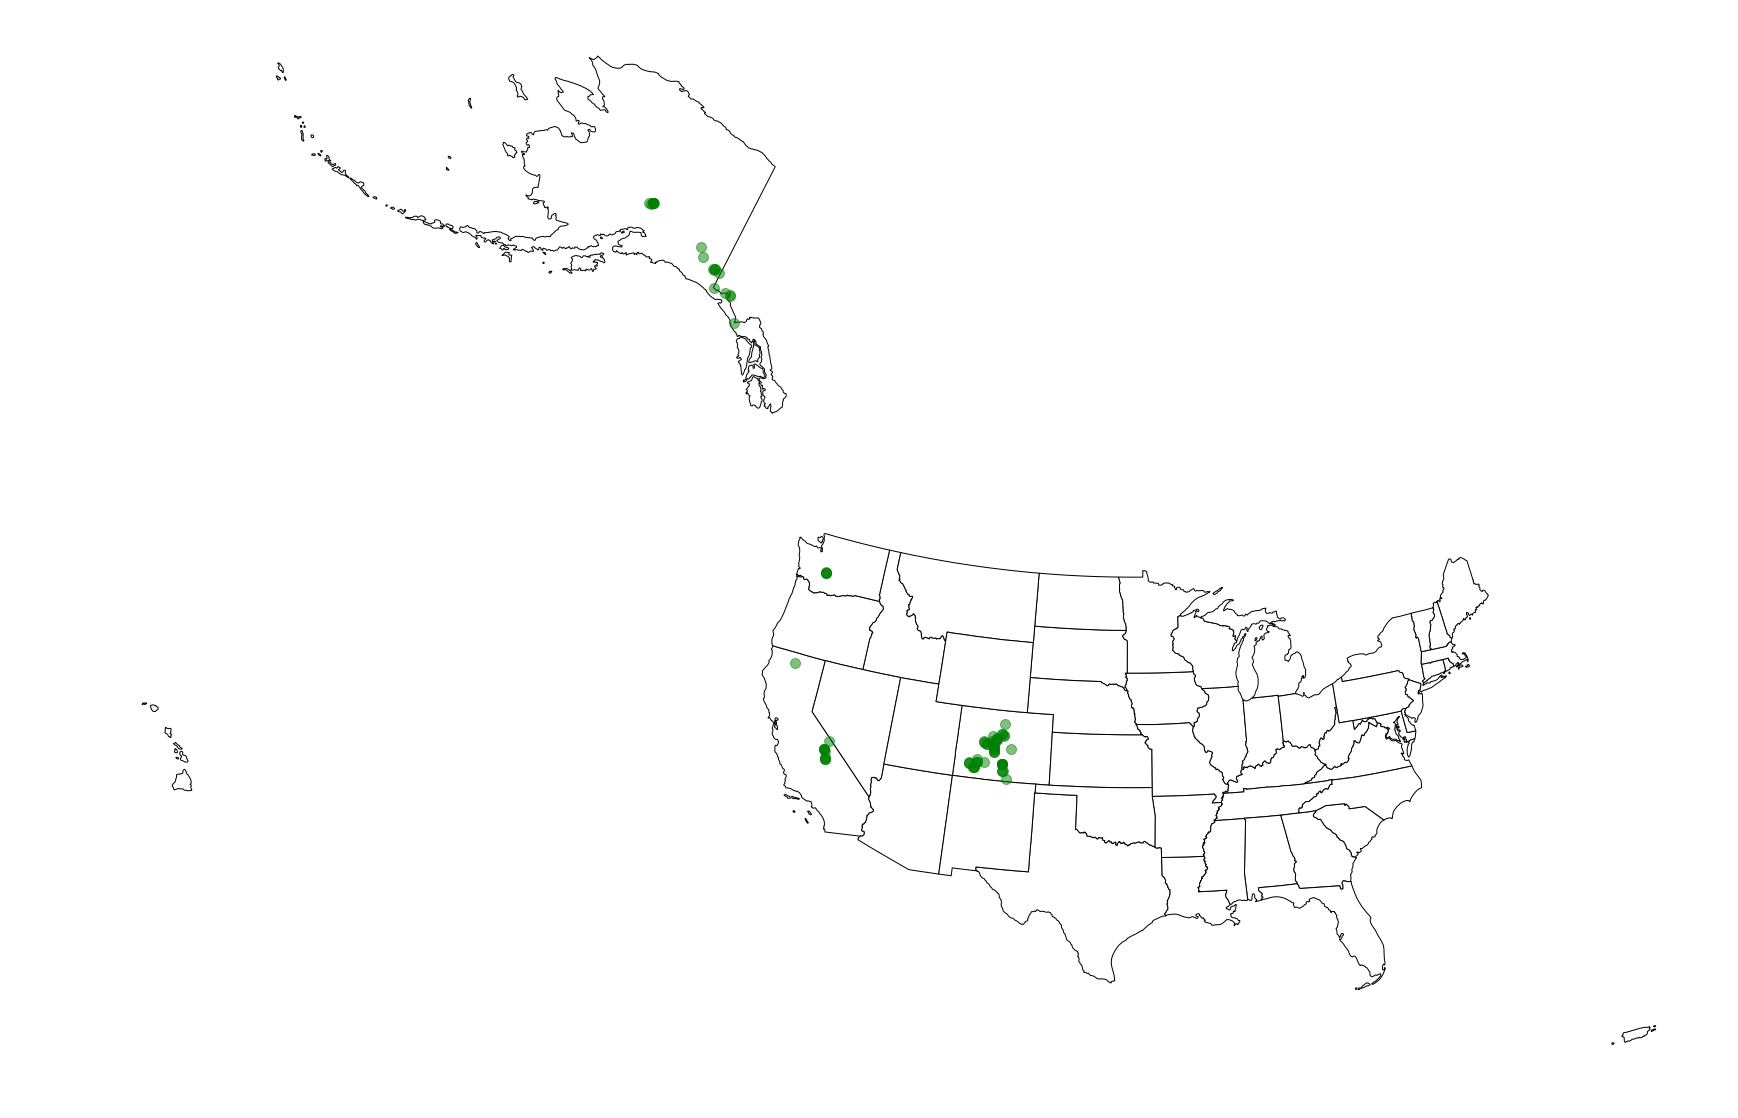

In [19]:
# set base layer plot
ax = states.plot(figsize=(30,20),
            edgecolor='black',
            color='white')

# turn off the axes
ax.axis('off')

# plot the 14er point layer on top of the map
gis_14ers.plot(color='green',
            markersize=100,
            alpha=0.5,
            ax=ax)